Latest

# MNIST CNN Classifier
Adapted from the [mnist_cnn keras example](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py) pointed to from the [AWS tutorial on containers](https://aws.amazon.com/getting-started/tutorials/train-deep-learning-model-aws-ec2-containers/):
```
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
```

Further adapted from Yan LeCunn's top performing MNIST paper:
[Regularization of Neural Networks using DropConnect](http://yann.lecun.com/exdb/publis/pdf/wan-icml-13.pdf)

https://github.com/j05t/mnist

# Setup libraries and parameters

In [0]:
import time
import pickle
import imageio
import os.path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import curve
from torchvision import datasets, transforms
#from torch.autograd import Variable

In [0]:
# For confusion matrix and 2D embedding
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

In [0]:
import PIL
import itertools

In [5]:
try:
    # Run this cell to mount your Google Drive.
    data_path = '/content/drive'
    from google.colab import drive
    drive.mount(data_path)
    data_path = os.path.join(data_path, 'My Drive')
except:
    # Just write locally if not in Colaboratory
    data_path = '.'

data_path = os.path.join(data_path, 'checkpoints')
try:
    !mkdir -p "$data_path"
except:
    print('Couldn\'t create', data_path)

print(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/checkpoints


In [0]:
!mkdir -p "$data_path"

In [0]:
# Control the resolution of figures plotted below. 200 dpi works well on my macbook
plt.rcParams['figure.dpi'] = 200

# Network definition
Adapted from this portion of the Keras example model
```
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
```
A few modifications:
* I changed the first layer to output 8 channels instead of 32, with the rationale being that a 3x3 kernel only spans 9 DOF. Any channels above 9 would start to become linearly dependent, but the nonlinearity after them might allow them to learn more?
* I added batch normalization after the first two convolutional layers because...well...everyone says they are helpful

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 32 channel convolutions
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 3, 1)
        self.bn3 = nn.BatchNorm2d(32)
        
        # 64 channel convolutions
        self.conv4 = nn.Conv2d(32, 64, 3, 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, 1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 3, 1)
        self.bn6 = nn.BatchNorm2d(64)
        self.conv7 = nn.Conv2d(64, 64, 3, 1)
        self.bn7 = nn.BatchNorm2d(64)
        self.conv8 = nn.Conv2d(64, 64, 3, 1)
        self.bn8 = nn.BatchNorm2d(64)
        
        # fully connected layers
        self.fc1 = nn.Linear(2*2*64, 128)
        self.bn9 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    # Output fc1 features
    def features(self, x):
        # input: 28 x 28 x 1
        cl1 = self.bn1(F.leaky_relu(self.conv1(x), negative_slope=0.3))
        # layer 1: 26 x 26 x 32
        cl2 = self.bn2(F.leaky_relu(self.conv2(cl1), negative_slope=0.3))
        # layer 2: 24 x 24 x 32
        cl3 = self.bn3(F.leaky_relu(self.conv3(cl2), negative_slope=0.3))
        # layer 3: 22 x 22 x 32
        cl4 = self.bn4(F.max_pool2d(F.leaky_relu(self.conv4(cl3), negative_slope=0.3),2,2))
        # layer 4: 10 x 10 x 32
        cl5 = self.bn5(F.leaky_relu(self.conv5(cl4), negative_slope=0.3))
        # layer 5: 8 x 8 x 64
        cl6 = self.bn6(F.leaky_relu(self.conv6(cl5), negative_slope=0.3))
        # layer 6: 6 x 6 x 64
        cl7 = self.bn7(F.leaky_relu(self.conv7(cl6), negative_slope=0.3))
        # layer 7: 4 x 4 x 64
        cl8 = self.bn8(F.leaky_relu(self.conv8(cl7), negative_slope=0.3))
        # layer 8: 2 x 2 x 64 -> 256
        fc1 = self.bn9(F.leaky_relu(self.fc1(cl8.view(-1, 2*2*64)), negative_slope=0.3))
        # layer 9: 128
        return fc1
    
    def forward(self, x):
        fc1 = self.features(x)
        # layer size 1 x 128
        fc2 = self.fc2(self.drop1(fc1))
        # layer 10 size 1x10
        return F.log_softmax(fc2, dim=1)

    def print_size(self):
        total_model_size = 0
        print("Model's state_dict:")
        # print out size of each set of parameter
        for param_tensor in self.state_dict():
            sz = self.state_dict()[param_tensor].size()

            # skip empty parameters (like batch normalization history length)
            if len(sz) == 0:
                continue

            total_model_size += np.prod(sz)
            if len(sz) > 1:
                print('{:16s} {:26s} : {} x {} = {:,}'.format(param_tensor, str(sz), sz[0], np.prod(sz[1:]), np.prod(sz)))
            else:
                print('{:16s} {:26s} : {:,}'.format(param_tensor, str(sz), np.prod(sz)))

        # print out total
        print('\n{:43} : {:,}'.format('Total Model Size',total_model_size))

In [0]:
class Optimizer:
    def __init__(self,
                 seed=1,
                 no_cuda=False,
                 #load_checkpoint=12,
                 load_checkpoint=False,
                 checkpoint_path='.',
                 checkpoint_prefix='mnist_'):

        self.seed = seed
        self.batch_size=512
        self.test_batch_size=1000
        
        torch.manual_seed(self.seed)
        self.epoch = 0
        
        use_cuda = not no_cuda and torch.cuda.is_available()
        self.kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.model = Net().to(self.device)
        
        #self.lr=0.01
        #self.momentum=0.5
        #self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum)
        #self.optimizer = optim.Adadelta(self.model.parameters(), lr=self.lr)
        self.optimizer = curve.Curve(self.model.parameters())
        #self.optimizer = optim.Adam(self.model.parameters())
        self.line_search_scales = []

        self.lr = self.optimizer.defaults['lr']
        self.loss_criterion = nn.CrossEntropyLoss(reduction='sum')

        self.checkpoint_path = checkpoint_path
        self.checkpoint_prefix = checkpoint_prefix
        self.save_checkpoints = True
        self.checkpoint_interval = 1
        
        

        # reset stats file
        if self.save_checkpoints:
            fn = os.path.join(self.checkpoint_path, '{}stats.pkl'.format(self.checkpoint_prefix))
            if os.path.exists(fn):
                os.remove(fn)
            
        if load_checkpoint:
            self.load_checkpoint(load_checkpoint)
            self.test(test_loader)
            
        # DataLoaders for train and test data
        self.train_loader = torch.utils.data.DataLoader(
            datasets.MNIST('../data', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.RandomAffine(15,translate=(0.1,0.1),scale=(0.9,1.1),shear=0.3,resample=PIL.Image.BILINEAR),
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=self.batch_size, shuffle=True, **self.kwargs)

        self.test_loader = torch.utils.data.DataLoader(
            datasets.MNIST('../data', train=False, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=self.test_batch_size, **self.kwargs)

    def set_line_search_scales(self, scales):
        self.line_search_scales = scales

    def set_learning_rate(self, lr):
        self.lr = lr
        #self.optimizer = optim.Adam(self.model.parameters(), lr)
        self.optimizer = curve.Curve(self.model.parameters(), lr)
        
    def eval_loss(self, step_factor, data, target):
        self.model.eval()
        self.optimizer.step(eval_only=True, step_factor=step_factor)
        output = self.model(data)
        self.optimizer.restore_state()
        return self.loss_criterion(output, target).item()
               
    def train(self):
        # Set model to be in training mode
        self.model.train()
        scales = self.line_search_scales
        
        # Accuracy accumulator 
        correct = 0
        total_loss = 0
        mini_batch_losses = []
        for data, target in self.train_loader:
            data, target = data.to(self.device), target.to(self.device)
            self.model.train()

            self.optimizer.zero_grad()
            output = self.model(data)

            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss = self.loss_criterion(output, target)
            loss.backward()
            total_loss += loss.item()
            
            # evaluate losses along step direction
            if len(scales) > 0:
                self.optimizer.save_state()
                batch_losses = [self.eval_loss(s, data, target) for s in scales]
            else:
                batch_losses = [loss.item()]
                
            # save average losses
            mini_batch_losses.append([l/len(data) for l in batch_losses])

            # compute and save step factor 1.0
            self.optimizer.step() # actually take this step

        return total_loss, correct, mini_batch_losses
        
    def test(self):
        # Set model to be in testing mode
        self.model.eval()

        # Accuracy accumulator 
        correct = 0
        total_loss = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)

                pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

                total_loss += self.loss_criterion(output, target).item() # sum up batch loss

        return total_loss, correct

    def run_epoch(self, endl=''):
        train_start = time.perf_counter()
        train_loss, train_correct, mini_batch_losses = self.train()
        train_end = time.perf_counter()
        train_count = len(self.train_loader.dataset)
        train_delta = train_end - train_start

        test_start = time.perf_counter()
        test_loss, test_correct = self.test()
        test_end = time.perf_counter()
        test_count = len(self.test_loader.dataset)
        test_delta = test_end - test_start

        print('\r {:1.1e} | {:5d} | {:5.1f}s, {:4.1f}s | {:6.4f}, {:6.4f} | {:5d}/{:5d} ({:.2f}%), {:4d}/{:4d} ({:5.2f}%)'.format(
            self.lr,
            self.epoch,
            train_delta, test_delta,
            train_loss/train_count, test_loss/test_count,
            train_correct, train_count, 100. * train_correct / train_count,
            test_correct, test_count, 100. * test_correct / test_count),
            end=endl, flush=True)
        self.epoch = self.epoch + 1
        
        if self.save_checkpoints:
            stats = {'losses' : mini_batch_losses,
                     'train_loss' : train_loss,
                     'train_count' : train_count,
                     'train_correct' : train_correct,
                     'test_loss' : test_loss,
                     'test_count' : test_count,
                     'test_correct' : test_correct}
            
            with open(os.path.join(self.checkpoint_path, '{}stats.pkl'.format(self.checkpoint_prefix)), 'ab') as f:
                pickle.dump(stats, f)

            if self.epoch % self.checkpoint_interval == 0:
                self.save_checkpoint()
        
    def run(self, epochs=None, lr=None, line_search_scales=None):
        if epochs is None:
            epochs = self.epochs
        if lr is not None:
            self.set_learning_rate(lr)
        if line_search_scales is not None:
            self.set_line_search_scales(line_search_scales)

        endl = '\n'
        for epoch in range(epochs):
            self.run_epoch(endl=endl)
        if endl is '':
            print('')            
    
    def run_schedule(self, schedule):
        print('Running schedule ' + '-'.join([str(b['epochs']) for b in schedule]))
        print('Learning | Epoch | Time          | Loss           | Accuracy')
        print('Rate     |       | Train,  Test  | Train,  Test   | Train,                Test')

        np.random.seed(self.seed)
        for sched in schedule:
            self.run(**sched)
            
    def save_checkpoint(self):
        checkpoint = {'epoch' : self.epoch,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict' : self.optimizer.state_dict(),
                      'loss_criterion' : self.loss_criterion}
        torch.save(checkpoint, os.path.join(self.checkpoint_path, '{}{:03}.pth'.format(self.checkpoint_prefix, self.epoch)))

    def load_checkpoint(self, epoch):
        checkpoint = torch.load(os.path.join(self.checkpoint_path, '{}{:03}.pth'.format(self.checkpoint_prefix, epoch)))
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.loss_criterion = checkpoint['loss_criterion']
        for parameter in self.model.parameters():
            parameter.requires_grad = False

In [0]:
def get_failures(opt):
    opt.model.eval()

    batch_offset = 0
    failure_indices = []
    target_all = torch.zeros((0),dtype=torch.long).to(opt.device)
    output_all = torch.zeros((0,10)).to(opt.device)
    with torch.no_grad():
        for data, target in opt.test_loader:
            data, target = data.to(opt.device), target.to(opt.device)
            output = opt.model(data)

            target_all = torch.cat((target_all, target))
            output_all = torch.cat((output_all, output))

            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            idx = np.where(pred.ne(target.view_as(pred)).to(torch.device("cpu")))[0]
            failure_indices += list(idx + batch_offset)

            batch_offset += pred.size(0)
    return np.array(failure_indices), output_all, target_all

def get_fc1_features(opt, dataloader):
    # Set model to be in testing mode
    opt.model.eval()
    with torch.no_grad():
        targets = torch.cat([target for data, target in dataloader])
        fc1 = torch.cat([opt.model.features(data.to(opt.device)) for data, target in dataloader])

        targets = targets.to(torch.device("cpu")).detach().numpy()
        fc1 = fc1.to(torch.device("cpu")).detach().numpy()

        return fc1, targets

## Create 10 Models

## Network Graph Plotting
These are the graph of functions back propagated through during the call to backward. This is adapted from the [PyTorch tutorial documentation](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)

In [0]:
# depth-first search through the back prop functions
def print_graph(fn, depth=0):
    if fn is None:
        return

    print('|'*depth, type(fn).__name__)
    for i in range(len(fn.next_functions)):
        print_graph(fn.next_functions[i][0], depth+1)

In [217]:
opt = Optimizer()

# Generate a random input and run it forward
batch_size = 2
input = torch.randn(batch_size,1,28,28).to(opt.device)
output = opt.model(input)

# Run the backward pass, which generates the graph
opt.model.zero_grad()
output.backward(torch.randn(batch_size,10).to(opt.device))

# Print the graph
print_graph(output.grad_fn)

 LogSoftmaxBackward
| AddmmBackward
|| AccumulateGrad
|| FusedDropoutBackward
||| CudnnBatchNormBackward
|||| LeakyReluBackward0
||||| AddmmBackward
|||||| AccumulateGrad
|||||| ViewBackward
||||||| CudnnBatchNormBackward
|||||||| LeakyReluBackward0
||||||||| CudnnConvolutionBackward
|||||||||| CudnnBatchNormBackward
||||||||||| LeakyReluBackward0
|||||||||||| CudnnConvolutionBackward
||||||||||||| CudnnBatchNormBackward
|||||||||||||| LeakyReluBackward0
||||||||||||||| CudnnConvolutionBackward
|||||||||||||||| CudnnBatchNormBackward
||||||||||||||||| LeakyReluBackward0
|||||||||||||||||| CudnnConvolutionBackward
||||||||||||||||||| CudnnBatchNormBackward
|||||||||||||||||||| MaxPool2DWithIndicesBackward
||||||||||||||||||||| LeakyReluBackward0
|||||||||||||||||||||| CudnnConvolutionBackward
||||||||||||||||||||||| CudnnBatchNormBackward
|||||||||||||||||||||||| LeakyReluBackward0
||||||||||||||||||||||||| CudnnConvolutionBackward
|||||||||||||||||||||||||| CudnnBatchNormBackward
|||||

## Print Model Parameter Sizes
How many weights/parameters are there in each expression (portion of a layer) that contribute to the gradient?

In [218]:
opt.model.print_size()

Model's state_dict:
conv1.weight     torch.Size([32, 1, 3, 3])  : 32 x 9 = 288
conv1.bias       torch.Size([32])           : 32
bn1.weight       torch.Size([32])           : 32
bn1.bias         torch.Size([32])           : 32
bn1.running_mean torch.Size([32])           : 32
bn1.running_var  torch.Size([32])           : 32
conv2.weight     torch.Size([32, 32, 3, 3]) : 32 x 288 = 9,216
conv2.bias       torch.Size([32])           : 32
bn2.weight       torch.Size([32])           : 32
bn2.bias         torch.Size([32])           : 32
bn2.running_mean torch.Size([32])           : 32
bn2.running_var  torch.Size([32])           : 32
conv3.weight     torch.Size([32, 32, 3, 3]) : 32 x 288 = 9,216
conv3.bias       torch.Size([32])           : 32
bn3.weight       torch.Size([32])           : 32
bn3.bias         torch.Size([32])           : 32
bn3.running_mean torch.Size([32])           : 32
bn3.running_var  torch.Size([32])           : 32
conv4.weight     torch.Size([64, 32, 3, 3]) : 64 x 288 = 18,

# Train (or load) the network

In [0]:
schedules = [
    [
        {"epochs" : 10, "lr" : 1e-3, "line_search_scales" : []},
        {"epochs" : 3, "lr" : 1e-3, "line_search_scales" : [0.0, 0.25, 0.5, 1.0, 2.0, 4.0]},
        {"epochs" : 3, "lr" : 1e-4, "line_search_scales" : [0.0, 0.25, 0.5, 1.0, 2.0, 4.0]},
    ],
]

In [220]:
seed = 1
optimizers = []
for idx, sched in enumerate(schedules):
    opt = Optimizer(checkpoint_path=data_path,
                                checkpoint_prefix='opt_{}_'.format(idx),
                                seed=seed,
                                load_checkpoint=False)
    opt.run_schedule(sched)
    optimizers.append(opt)
    np.random.seed(seed)

Running schedule 10-3-3
Learning | Epoch | Time          | Loss           | Accuracy
Rate     |       | Train,  Test  | Train,  Test   | Train,                Test
 1.0e-03 |     0 |  16.4s,  1.8s | 0.4862, 0.0628 | 52760/60000 (87.93%), 9841/10000 (98.41%)
 1.0e-03 |     1 |  17.0s,  1.8s | 0.1076, 0.0539 | 58290/60000 (97.15%), 9843/10000 (98.43%)
 1.0e-03 |     2 |  17.0s,  1.9s | 0.0798, 0.1075 | 58690/60000 (97.82%), 9646/10000 (96.46%)
 1.0e-03 |     3 |  17.2s,  1.8s | 0.0662, 0.0347 | 58847/60000 (98.08%), 9882/10000 (98.82%)
 1.0e-03 |     4 |  17.0s,  1.8s | 0.0576, 0.0278 | 59002/60000 (98.34%), 9903/10000 (99.03%)
 1.0e-03 |     5 |  17.0s,  1.8s | 0.0527, 0.0365 | 59058/60000 (98.43%), 9892/10000 (98.92%)
 1.0e-03 |     6 |  17.6s,  1.9s | 0.0493, 0.0367 | 59121/60000 (98.53%), 9883/10000 (98.83%)
 1.0e-03 |     7 |  16.9s,  1.8s | 0.0467, 0.0303 | 59140/60000 (98.57%), 9911/10000 (99.11%)
 1.0e-03 |     8 |  16.8s,  1.9s | 0.0415, 0.0234 | 59244/60000 (98.74%), 9931/10000

In [226]:
opt_slc = slice(0,len(schedules),1)
stat_slc = slice(13, 16, 1)
train_error=[]
test_error=[]
train_loss=[]
test_loss=[]
train_losses=[]
for opt in optimizers[opt_slc]:
    with open(os.path.join(opt.checkpoint_path, '{}stats.pkl'.format(opt.checkpoint_prefix)), 'rb') as f:
        stats = []
        while 1:
            try:
                stats.append(pickle.load(f))
            except EOFError:
                break
    print(len(stats))
    stats = stats[stat_slc]
    print(len(stats))
    test_error.append(np.hstack([(s['test_count']-s['test_correct'])/s['test_count'] for s in stats]))
    train_error.append(np.hstack([(s['train_count']-s['train_correct'])/s['train_count'] for s in stats]))
    test_loss.append(np.hstack([s['test_loss']/s['test_count'] for s in stats]))
    train_loss.append(np.hstack([s['train_loss']/s['train_count'] for s in stats]))
    train_losses.append(np.vstack([np.vstack(s['losses']) for s in stats]))  

16
3


(354, 6)
(3,)
[0.0, 0.25, 0.5, 1.0, 2.0, 4.0]
[0.05180212 0.05124297 0.05069162 0.04963368 0.04764546 0.04420529]


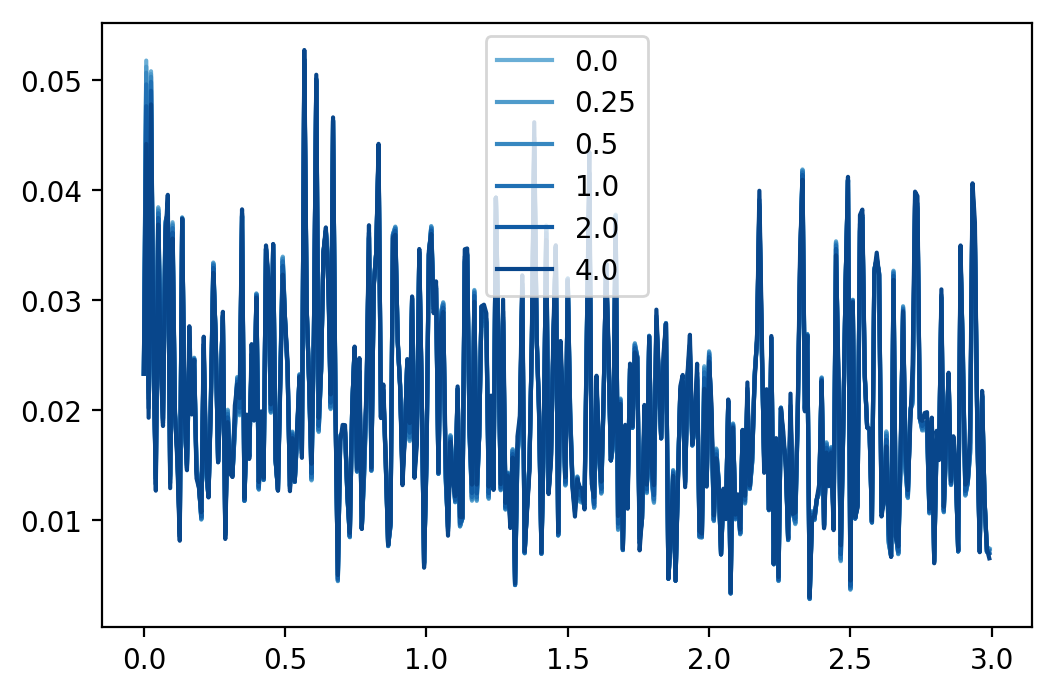

In [227]:
print(train_losses[0].shape)
cmap=plt.get_cmap('Blues')
scales = optimizers[0].line_search_scales
x_rng = np.arange(0, train_losses[0].shape[0])/len(optimizers[0].train_loader)
handles = plt.plot(x_rng, train_losses[0])
for idx, h in enumerate(handles):
    h.set_color(cmap(idx/len(scales)/2+0.5))
    h.set_label(scales[idx])
plt.legend()
print(test_error[0].shape)
print(optimizers[0].line_search_scales)
print(train_losses[0][1,:])

In [0]:
def plot_losses_and_errors(schedules, train_error, test_error, train_loss, test_loss, train_losses):
    train_cmap = plt.get_cmap('Blues')
    test_cmap = plt.get_cmap('Reds')

    # Create labels for each schedule (e.g. '100-50-100')
    lbls=[]
    for s in schedules[slc]:
        epochs = [str(b['epochs']) for b in s]
        lbls.append('-'.join(epochs))

    schcnt = len(lbls)

    def set_handles(handles, label, cmap):
        linestyles = ['solid', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)), (0, (1, 5)), 'dotted']
        markers = ['o', '+', 'v', 'D', 'p', 'o']

        for h, lbl, clr in zip(handles, lbls, np.arange(0,1,1/schcnt)*0.4+0.6):
            h.set_linestyle('-')
            h.set_color(cmap(clr))
            h.set_marker('')
            h.set_markersize(2)
            h.set_label(label + ' ' + lbl)
            h.set_linewidth(1)

    show_train = True
    show_test = True

    fig, ax = plt.subplots(2,1, figsize=(10,12), dpi=100)

    # Plot Losses
    plt.subplot(211)

    epochs = len(train_error[0])
    x_coords = np.arange(0, epochs)+1
    x_ticks = np.arange(0, epochs, step=1)+1

    if show_train:
        handles = plt.plot(x_coords, np.vstack(train_loss).transpose())
        set_handles(handles, 'Training (Avg)', train_cmap)

    if show_test:
        handles = plt.plot(x_coords, np.vstack(test_loss).transpose())
        set_handles(handles, 'Test (Avg)', test_cmap)

    plt.legend()
    plt.xticks(x_ticks)
    plt.xlim(1, epochs, 10)
    plt.yscale('log')
    plt.ylim(1e-3, 1e-0)
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy (nits)')
    plt.title('Losses')
    plt.grid()

    # Plot Error Rates
    plt.subplot(212)

    if show_train:
        handles = plt.plot(x_coords, np.vstack(train_error).transpose()*100)
        set_handles(handles, 'Training', train_cmap)

    if show_test:
        handles = plt.plot(x_coords, np.vstack(test_error).transpose()*100)
        set_handles(handles, 'Test', test_cmap)

    plt.legend()
    plt.xticks(x_ticks)
    plt.xlim(1, epochs)
    ymax = 10
    plt.ylim(0, ymax)
    plt.yticks(np.arange(0, ymax, step=ymax/10))
    plt.xlabel('Epoch')
    plt.ylabel('Error Rate (%)')
    plt.title('Error Rates')
    plt.grid()
    plt.show()

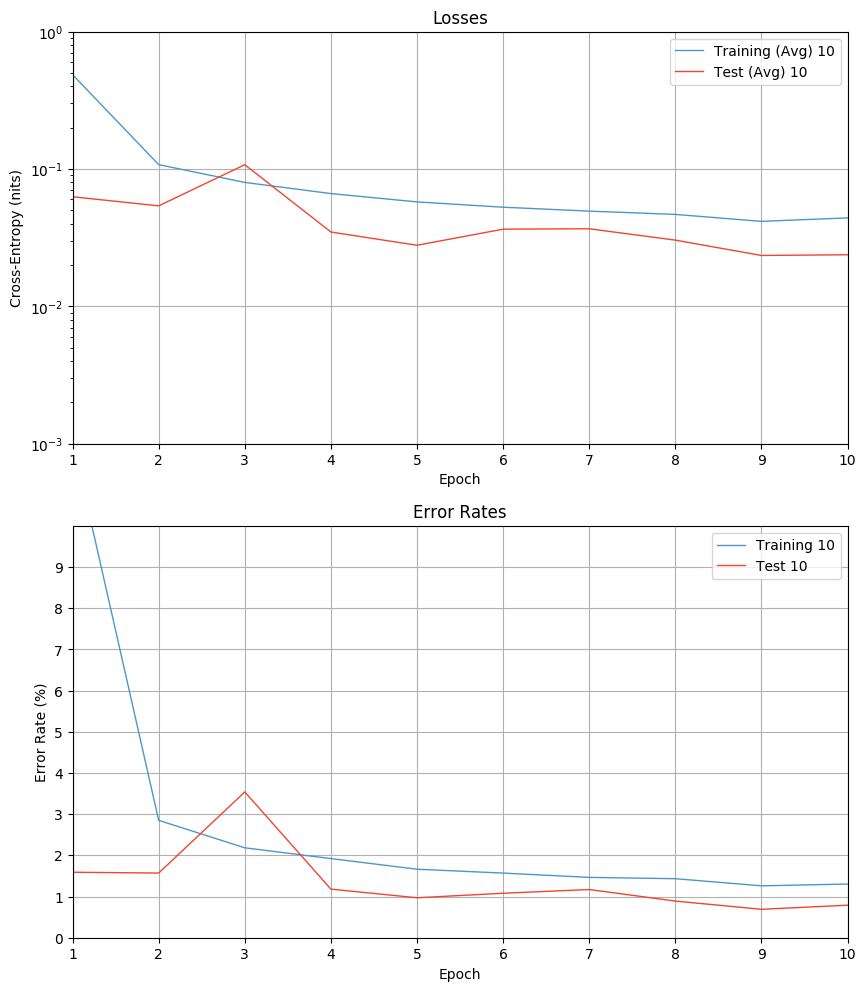

In [108]:
plot_losses_and_errors(schedules, train_error, test_error, train_loss, test_loss, train_losses)

# Visualization Code

## Create a 2800 x 2800 tiled image from the 10,000 test images

In [0]:
def tile_digits(digits, outputs=None, shape='Square', train=False):
    ds = datasets.MNIST('../data', train=train, transform=transforms.Compose([
                           transforms.ToTensor()]))

    cmap = mpl.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)
    
    def get_img(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < -10:
            return np.zeros((28,28,3)).astype('uint8')
        
        idx = digits[idx]
        if idx < 0:
            clr = cmap(-idx-1)
            img = np.full((28,28,1), 255)
        else:
            clr = cmap(ds[idx][1])
            img = ds[idx][0].numpy().reshape(28,28)*255
            
        return np.dstack([(img*clr[c]).astype('uint8') for c in range(3)])

    def get_target(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < 0:
            return -1
        return ds[digits[idx]][1]

    def get_class(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < 0:
            return -1
        return outputs[digits[idx]].argmax(dim=0, keepdim=True).numpy().T[0]

    cnt = len(digits)
    if shape is 'Square':
        cols = np.ceil(np.sqrt(cnt)).astype('int64')
    elif shape is 'Horizontal':
        cols = cnt
    else:
        cols = 1

    img = np.vstack([np.hstack([get_img(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])
    targets = np.vstack([np.hstack([get_target(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])
    if outputs is None:
        return img, targets
    else:
        classes = np.vstack([np.hstack([get_class(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])

    return img, targets, classes

In [0]:
tiled, target = tile_digits(range(10000))
imageio.imwrite(os.path.join(data_path, 'tiled.png'), tiled)

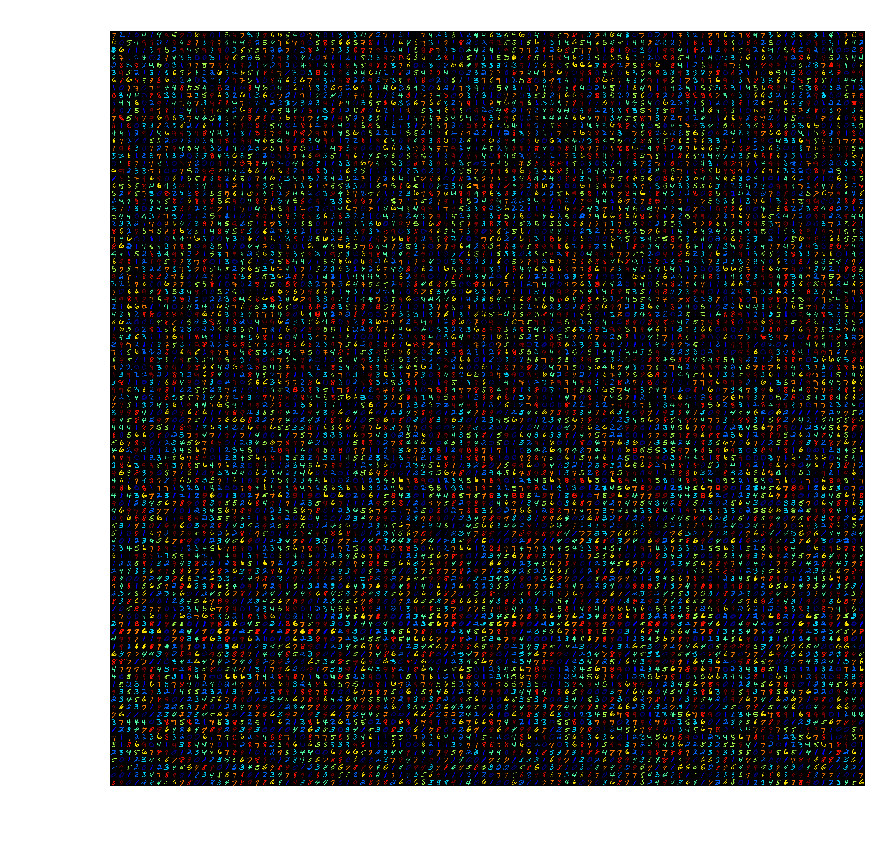

In [21]:
fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
plt.imshow(tiled)
plt.show()

## Inspect Failures

In [0]:
failure_indices, output_all, target_all = get_failures(optimizers[-1])

In [23]:
target_failures = target_all[failure_indices]
failure_idx_by_digit = list(map(lambda digit: np.where(target_failures.eq(digit).to(torch.device("cpu")))[0], range(0,10)))

# Print sorted failures
sorted_failures = np.hstack(failure_idx_by_digit)
fail_img, targets, classes = tile_digits(failure_indices[sorted_failures], output_all.to(torch.device("cpu")))

print(len(failure_indices))
print('Classifications:\n', classes)
imageio.imwrite(os.path.join(data_path, 'sorted_failures.png'), fail_img)


79
Classifications:
 [[ 5  6  2  8  7  7  7  7  2]
 [ 7  7  6  7  7  4  7  3  7]
 [ 0  7  3  7  7  4  7  7  5]
 [ 5  5  2  6  9  9  9  7  3]
 [ 6  3  6  5  8  5  1  0  8]
 [ 0  3  2  2  3  2  4  9  6]
 [ 2  2  3  7  7  4  5  5  5]
 [ 4  5  5  4  4  4  8  5  4]
 [ 4  3  7  5  8  3  7 -1 -1]]


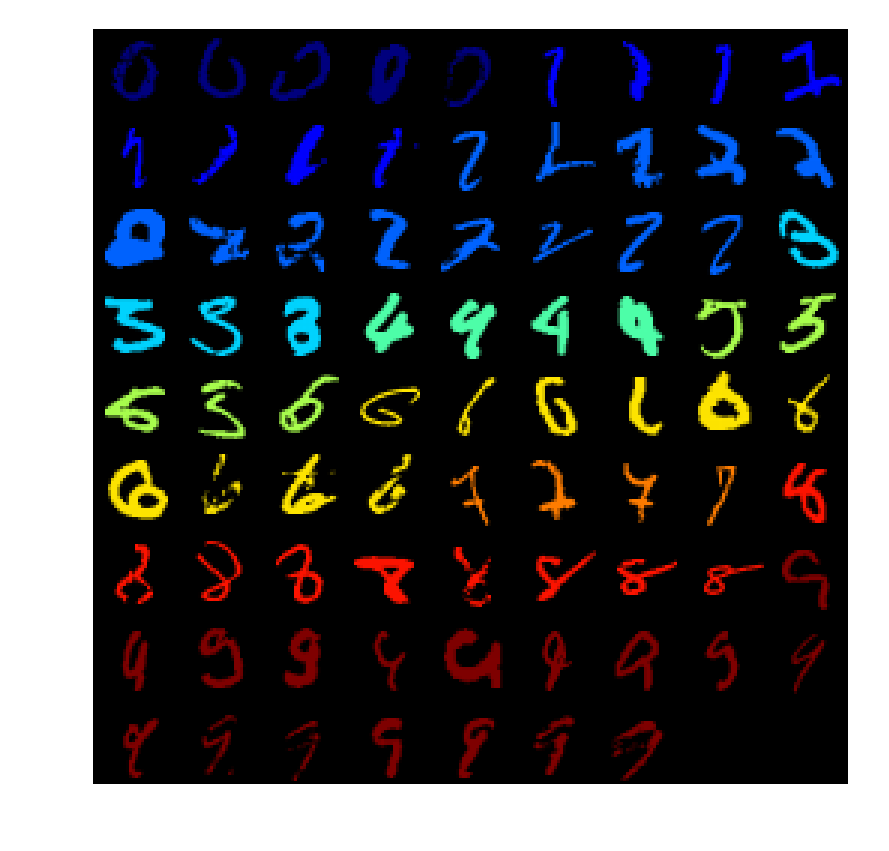

In [24]:
fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
plt.imshow(fail_img)
plt.show()

## Plot t-SNE embedding of fc1 features
First extract the fc1 features for each test image and their ground truth values

In [25]:
epochs = optimizers[-1].epoch
fc1 = []
target = []
epochs_list = range(epochs-3, epochs)
for epoch in epochs_list:
    optimizers[-1].load_checkpoint(epoch+1)
    f, t = get_fc1_features(optimizers[-1], test_loader)
    fc1.append(f)
    target.append(t)
    
fc1 = np.vstack(fc1)
target = np.hstack(target)

NameError: ignored

Embed the 10 dimensional softmax output in 2D space

In [0]:
X_embedded = TSNE(n_components=2).fit_transform(fc1)

Plot the 2D embedding, color-coded by the ground truth value

In [0]:
cmap = mpl.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)

#def onclick(event):
#    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
#          ('double' if event.dblclick else 'single', event.button,
#           event.x, event.y, event.xdata, event.ydata))

fig, ax = plt.subplots(len(epochs_list), 1, figsize=(6,len(epochs_list)*5), dpi=200)

#cid = fig.canvas.mpl_connect('button_release_event', onclick)
for i, epoch in enumerate(epochs_list):
    test_count = len(test_loader.dataset)
    idx = range(test_count*i, test_count*(i+1))
    cs=ax[i].scatter(X_embedded[idx,0], X_embedded[idx,1],
                   norm=mpl.colors.Normalize(vmin=-0.5, vmax=9.5),
                   s=.5, c=target[idx], cmap=cmap)

    cb = plt.colorbar(cs, ax=ax[i])
    cb.set_ticks(np.arange(0,10))
    cb.set_ticklabels(np.arange(0, 10))

    ax[i].set_xticks([])
    ax[i].set_yticks([])


    #ax[1].set_xticks([])
    #ax[1].set_yticks([])


len(target)

### How about just 4, 7 and 9

In [0]:
lst = [4,7,9]
fc1_sub=fc1[np.isin(target,lst),:]
target_sub=target[np.isin(target,lst)]

In [0]:
X_embedded_sub = TSNE(n_components=2).fit_transform(fc1_sub)

In [0]:
fig, ax = plt.subplots(len(epochs_list),1, figsize=(6,5*len(epochs_list)), dpi=200)

cmap = mpl.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)

for i, epoch in enumerate(epochs_list):
    test_count = len(target_sub)//len(epochs_list)
    idx = range(test_count*i, test_count*(i+1))

    cs=ax[i].scatter(X_embedded_sub[idx,0], X_embedded_sub[idx,1], s=.5, c=target_sub[idx], cmap=cmap, norm=mpl.colors.Normalize(vmin=-0.5, vmax=9.5))
    cb = plt.colorbar(cs, ax=ax[i])
    cb.set_ticks(np.arange(0,10))
    cb.set_ticklabels(np.arange(0, 10))

    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
len(target_sub)

## What are the Nearest Neighbors for Failures?

In [0]:
# Get a data loader with no augmentation
train_loader_fc1 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=optimizers[-1].batch_size, shuffle=False, **optimizers[-1].kwargs)

train_fc1, train_target=get_fc1_features(optimizers[-1], train_loader_fc1)

In [0]:
nbrs = NearestNeighbors(n_neighbors=16, algorithm='ball_tree').fit(train_fc1)
distances, indices = nbrs.kneighbors(fc1[failure_indices[sorted_failures],:])

In [0]:
cnt = len(sorted_failures)

failure_classes = output_all[failure_indices[sorted_failures]].argmax(dim=1, keepdim=True) # get the index of the max log-probability

failure_img = tile_digits(failure_indices[sorted_failures], shape='Vertical')[0]
failure_classification_img = tile_digits((-failure_classes.to(torch.device("cpu")).numpy()-1).transpose()[0], shape='Vertical')[0]
neigh_img = np.vstack([tile_digits(indices[idx,:], shape='Horizontal', train=True)[0] for idx in range(cnt)])

imageio.imwrite(os.path.join(data_path, 'neighbors_train.png'), np.hstack([failure_img, failure_classification_img, neigh_img]))

fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
ax.imshow(np.hstack([failure_img, failure_classification_img, neigh_img]))

plt.show()

## Plot Confusion Matrix
The confusion matrix plotting function was copied from [Yassine Ghouzam's great notebook](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
pred_all = output_all.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            
# compute the confusion matrix
confusion_mtx = confusion_matrix(target_all.to(torch.device("cpu")), pred_all.to(torch.device("cpu"))) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Look at weights/kernels

In [0]:
def plot_kernels(conv_layer):
    out_dim = conv_layer.size()[0]
    in_dim = conv_layer.size()[1]
    kw = conv_layer.size()[2]
    kh = conv_layer.size()[3]

    for row in range(0,out_dim):
        fig, ax = plt.subplots(1, in_dim)
        for col in range(0,in_dim):
            if in_dim>1:
                col_ax = ax[col]
            else:
                col_ax = ax
            col_ax.imshow(conv_layer[row][col].numpy(), cmap='binary')
            col_ax.axis('off')
        plt.show()

In [0]:
plot_kernels(optimizers[-1].model.state_dict()['conv1.weight'].permute(1,0,2,3).to(torch.device("cpu")))

In [0]:
plot_kernels(optimizers[-1].model.state_dict()['conv2.weight'].to(torch.device("cpu")))